In [25]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

In [7]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 284807 samples in total but only 492 cases of fraud


### Feature Scaling

In [8]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[  3.91864870e-15   5.68268579e-16  -8.76173610e-15   2.81111774e-15
  -1.55210305e-15   2.04012968e-15  -1.69895265e-15  -1.95815061e-16
  -3.14764036e-15   1.77292451e-15   9.28952385e-16  -1.80326603e-15
   1.67488824e-15   1.47562122e-15   3.50109813e-15   1.39243845e-15
  -7.46653801e-16   4.25873794e-16   9.02016885e-16   5.12684532e-16
   1.47198194e-16   8.04210901e-16   5.28245009e-16   4.45826738e-15
   1.42689564e-15   1.70163965e-15  -3.67160561e-16  -1.21815215e-16
   8.83496193e+01]
[  3.83647578e+00   2.72681045e+00   2.29902117e+00   2.00467678e+00
   1.90507436e+00   1.77494002e+00   1.53039520e+00   1.42647385e+00
   1.20698823e+00   1.18558965e+00   1.04185143e+00   9.98399911e-01
   9.90567315e-01   9.18902320e-01   8.37800459e-01   7.67816427e-01
   7.21370915e-01   7.02536891e-01   6.62659610e-01   5.94323307e-01
   5.39523633e-01   5.26640906e-01   3.89949292e-01   3.66807083e-01
   2.71729873e-01   2.32542076e-01   1.62918619e-01   1.08954579e-01
   6.25598494e+

In [9]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[ -2.25678488e-15  -1.71239117e-16   1.78595723e-16  -1.28963171e-15
   1.58007541e-15  -9.37326021e-17  -4.94536068e-17   5.94282165e-17
   1.06682404e-15   4.52466744e-16   2.44123467e-15   2.51412842e-15
  -9.21023919e-16  -1.01232363e-15  -1.29522625e-16  -9.85596926e-17
   1.19923593e-15   3.18853147e-16  -1.67186006e-16   4.18564063e-16
   8.94645076e-17  -3.51601875e-16  -1.16601660e-15   1.28679343e-16
  -2.51010111e-15   2.03088636e-16  -7.54884618e-18   1.28996763e-16
   2.27024770e-13]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


### Preliminary plotting

[ 1.19185711 -1.35835406 -0.96627171 -1.15823309 -0.42596588  1.22965763
 -0.64426944 -0.89428608 -0.33826175]


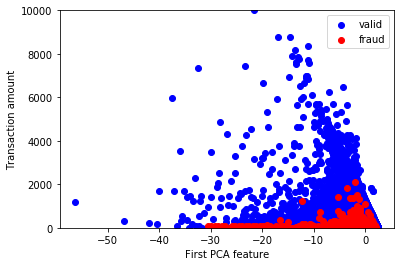

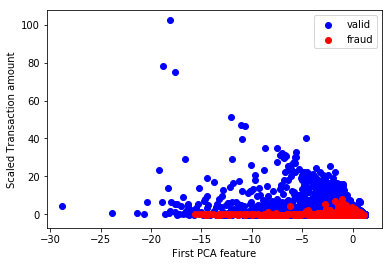

In [10]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

data_fraud_sc = data_sc[np.where(labels == 1)]
data_valid_sc = data_sc[np.where(labels == 0)]
plt.scatter(data_valid_sc[:, 0], data_valid_sc[:, -1], c='b')
plt.scatter(data_fraud_sc[:, 0], data_fraud_sc[:, -1], c='r')
# plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Scaled Transaction amount')
plt.show()

### Setting up cross-validation

In [11]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [18]:
def train_binary_SVM(data, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)

        svm.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = svm.predict(data[folds[i]])

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [19]:
train_binary_SVM(data);

Fold 0
[[56819    44]
 [   37    62]]
Fold 1
[[56827    36]
 [   35    64]]
Fold 2
[[56825    38]
 [   35    63]]
Fold 3
[[56833    30]
 [   35    63]]
Fold 4
[[56814    49]
 [   34    64]]
Final Confusion Matrix
[[  5.68236000e+04   3.94000000e+01]
 [  3.52000000e+01   6.32000000e+01]]


#### Linear SVM with Scaling

In [20]:
train_binary_SVM(data_sc);

Fold 0
[[45920 10943]
 [    2    97]]
Fold 1
[[48213  8650]
 [    3    96]]
Fold 2
[[47397  9466]
 [    5    93]]
Fold 3
[[46789 10074]
 [    3    95]]
Fold 4
[[52361  4502]
 [    8    90]]
Final Confusion Matrix
[[  4.81360000e+04   8.72700000e+03]
 [  4.20000000e+00   9.42000000e+01]]


#### Linear SVM with Scaling and Class Weights

In [21]:
train_binary_SVM(data_sc, class_weight='balanced');

Fold 0
[[33484 23379]
 [    1    98]]
Fold 1
[[34893 21970]
 [    2    97]]
Fold 2
[[33732 23131]
 [    1    97]]
Fold 3
[[33914 22949]
 [    0    98]]
Fold 4
[[34640 22223]
 [    1    97]]
Final Confusion Matrix
[[  3.41326000e+04   2.27304000e+04]
 [  1.00000000e+00   9.74000000e+01]]


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data_sc, kernel='rbf');

In [ ]:
train_binary_SVM(data_sc, kernel='rbf', class_weight='balanced');

#### Polynomial Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data_sc, kernel='poly');

In [ ]:
train_binary_SVM(data_sc, kernel='poly', class_weight='balanced');

### Logistic Regression

In [26]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        pred_valid = model.predict(data[valid_splits[i]])
        err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        pred_fraud = model.predict(data[fraud_splits[i]])
        err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        err += err_fold
        err_valid += err_valid_fold
        err_fraud += err_fraud_fold
    err /= 5
    err_valid /= 5
    err_fraud /= 5
    print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [27]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fraud_errs = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    _,_,fe = train_logistic_regression(data_sc, cw, C)
    fraud_errs.append(fe)

idx = np.argmin(fraud_errs)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000754889224395 Valid Error: 0.000123102896435 Fraud Error 0.363636363636


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000930444857975 Valid Error: 0.000193447408684 Fraud Error 0.424242424242


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000860237706501 Valid Error: 0.000105516768373 Fraud Error 0.438775510204


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000807570091817 Valid Error: 8.79306403109e-05 Fraud Error 0.418367346939


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.000930461192746 Valid Error: 0.000193447408684 Fraud Error 0.428571428571
FINAL Error: 0.000856720614687 Valid Error: 0.000140689024497 Fraud Error 0.414718614719
Checking class weight None and coefficient 0.016681005372000592


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000790000351111 Valid Error: 0.000123102896435 Fraud Error 0.383838383838


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000948000421334 Valid Error: 0.000193447408684 Fraud Error 0.434343434343


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000860237706501 Valid Error: 0.000105516768373 Fraud Error 0.438775510204


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000825125963378 Valid Error: 0.000105516768373 Fraud Error 0.418367346939


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.000877793578062 Valid Error: 0.00015827515256 Fraud Error 0.418367346939
FINAL Error: 0.000860231604077 Valid Error: 0.000137171798885 Fraud Error 0.418738404453
Checking class weight None and coefficient 0.027825594022071243


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000737333661037 Valid Error: 0.000105516768373 Fraud Error 0.363636363636


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000930444857975 Valid Error: 0.000193447408684 Fraud Error 0.424242424242


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000877793578062 Valid Error: 0.000123102896435 Fraud Error 0.438775510204


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000825125963378 Valid Error: 0.000105516768373 Fraud Error 0.418367346939


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.000860237706501 Valid Error: 0.00015827515256 Fraud Error 0.408163265306
FINAL Error: 0.000846187153391 Valid Error: 0.000137171798885 Fraud Error 0.410636982066
Checking class weight None and coefficient 0.046415888336127774


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000719778097679 Valid Error: 0.000105516768373 Fraud Error 0.353535353535


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000895333731259 Valid Error: 0.000193447408684 Fraud Error 0.40404040404


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000877793578062 Valid Error: 0.000123102896435 Fraud Error 0.438775510204


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000825125963378 Valid Error: 0.000105516768373 Fraud Error 0.418367346939


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.00084268183494 Valid Error: 0.00015827515256 Fraud Error 0.397959183673
FINAL Error: 0.000832142641064 Valid Error: 0.000137171798885 Fraud Error 0.402535559678
Checking class weight None and coefficient 0.0774263682681127


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000737333661037 Valid Error: 0.000123102896435 Fraud Error 0.353535353535


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000877778167901 Valid Error: 0.000175861280622 Fraud Error 0.40404040404


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000895349449623 Valid Error: 0.00015827515256 Fraud Error 0.428571428571


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000825125963378 Valid Error: 0.000105516768373 Fraud Error 0.418367346939


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.00084268183494 Valid Error: 0.00015827515256 Fraud Error 0.397959183673
FINAL Error: 0.000835653815376 Valid Error: 0.00014420625011 Fraud Error 0.400494743352
Checking class weight None and coefficient 0.1291549665014884


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000737333661037 Valid Error: 0.000123102896435 Fraud Error 0.353535353535


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000860222604543 Valid Error: 0.000175861280622 Fraud Error 0.393939393939


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000860237706501 Valid Error: 0.00015827515256 Fraud Error 0.408163265306


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.00084268183494 Valid Error: 0.000105516768373 Fraud Error 0.428571428571


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.00084268183494 Valid Error: 0.00015827515256 Fraud Error 0.397959183673
FINAL Error: 0.000828631528392 Valid Error: 0.00014420625011 Fraud Error 0.396433725005
Checking class weight None and coefficient 0.21544346900318834


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000754889224395 Valid Error: 0.000123102896435 Fraud Error 0.363636363636


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000860222604543 Valid Error: 0.000175861280622 Fraud Error 0.393939393939


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000895349449623 Valid Error: 0.000193447408684 Fraud Error 0.408163265306


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000825125963378 Valid Error: 0.000123102896435 Fraud Error 0.408163265306


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.00084268183494 Valid Error: 0.00015827515256 Fraud Error 0.397959183673
FINAL Error: 0.000835653815376 Valid Error: 0.000154757926947 Fraud Error 0.394372294372
Checking class weight None and coefficient 0.3593813663804626


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000754889224395 Valid Error: 0.000123102896435 Fraud Error 0.363636363636


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000860222604543 Valid Error: 0.000175861280622 Fraud Error 0.393939393939


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000895349449623 Valid Error: 0.000211033536746 Fraud Error 0.397959183673


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000825125963378 Valid Error: 0.000123102896435 Fraud Error 0.408163265306


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.00084268183494 Valid Error: 0.00015827515256 Fraud Error 0.397959183673
FINAL Error: 0.000835653815376 Valid Error: 0.00015827515256 Fraud Error 0.392331478046
Checking class weight None and coefficient 0.5994842503189409


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000754889224395 Valid Error: 0.000123102896435 Fraud Error 0.363636363636


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000860222604543 Valid Error: 0.000175861280622 Fraud Error 0.393939393939


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000895349449623 Valid Error: 0.000211033536746 Fraud Error 0.397959183673


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000807570091817 Valid Error: 0.000123102896435 Fraud Error 0.397959183673


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KeyboardInterrupt: 

### We see that as we improve fraud accuracy, valid accuracy decreases and vice versa. For the best fraud accuracy, the results suggest that we utilize the scaled data, balanced class weights and a strong regularization (small C coefficient)